# Color models


## 1. Install and Import Required Libraries

We will use PyTorch, torchvision, numpy, matplotlib, and tqdm. If running locally, ensure these packages are installed.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
import base64
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import transforms
from io import BytesIO
from PIL import Image, ImageOps
from tqdm import tqdm
import cv2
import numpy as np
from PIL import Image
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
import io

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
HR = 256
LR = 64
max_training_time = 60*5
display_interval = 30

# https://www.kaggle.com/datasets/chetankv/dogs-cats-images
# https://www.kaggle.com/datasets/nerfviking/fantasyscifi-full-body-character-concepts
# https://www.kaggle.com/datasets/hlrhegemony/pokemon-image-dataset
experiments = {
    "fantasy": ("./data/fantasy", "checkpoints/UNet128_2025-09-12_08-24-21_fantasy.pth"),
    "cats_and_dogs": ("./data/cats_and_dogs/dataset/training_set", "checkpoints/UNet128_2025-09-08_17-57-30_cats_and_dogs.pth"),
    "pokemon": ("./data/pokemon_archive","UNet128_2025-09-12_11-03-12_pokemon.pth"),
    "dragon": ("utils/dataset_fetcher/datasets/", "checkpoints/UNet128_2025-09-12_19-47-15_dragon.pth"),
}

experiment_name = "fantasy"
data_root, good_weights = experiments[experiment_name]

## 3. Define a Vision Mmodel for a Diffusion Model Architecture

* **Sinusoidal Timestep Embedding**
  * → Encodes diffusion step (time) as a multi-frequency vector. Lets the model “know” how much noise is present and what stage of denoising it’s in.
* **Optional Self-Attention at Lower Resolutions (e.g. 16×16)**
  * → Lets distant parts of the image “talk to each other,” useful for global structure (symmetry, object coherence). Limited to low-res maps to save compute.
* **SiLU/Swish activations**
  * → Smooth nonlinearities, empirically better than ReLU in diffusion U-Nets.

In [3]:

# -----------------------------
# Positional embedding for timestep/sigma
# -----------------------------
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb


# -----------------------------
# Simple self-attention block
# -----------------------------
class SelfAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        q, k, v = self.qkv(h).chunk(3, dim=1)
        q = q.reshape(B, C, H*W).permute(0, 2, 1)  # B, HW, C
        k = k.reshape(B, C, H*W)                    # B, C, HW
        attn = torch.bmm(q, k) / (C ** 0.5)
        attn = F.softmax(attn, dim=-1)
        v = v.reshape(B, C, H*W).permute(0, 2, 1)
        h = torch.bmm(attn, v).permute(0, 2, 1).reshape(B, C, H, W)
        return x + self.proj(h)


# -----------------------------
# Residual block with optional attention
# -----------------------------
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim, use_attention=False):
        super().__init__()
        self.use_attention = use_attention
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Linear(emb_dim, out_ch)
        if use_attention:
            self.attn = SelfAttention(out_ch)
        if in_ch != out_ch:
            self.skip = nn.Conv2d(in_ch, out_ch, 1)
        else:
            self.skip = nn.Identity()

    def forward(self, x, t_emb):
        h = F.relu(self.conv1(x))
        h = h + self.time_mlp(t_emb)[:, :, None, None]
        h = F.relu(self.conv2(h))
        if self.use_attention:
            h = self.attn(h)
        return h + self.skip(x)


# -----------------------------
# 64x64 RGB U-Net (channel-corrected)
# -----------------------------
class UNet128(nn.Module):
    def __init__(self, in_channels=3, base_ch=64, emb_dim=128, use_attention=True):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(emb_dim),
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU()
        )

        # Down path
        self.inc = ResBlock(in_channels, base_ch, emb_dim)
        self.down1 = ResBlock(base_ch, base_ch*2, emb_dim)
        self.down2 = ResBlock(base_ch*2, base_ch*4, emb_dim, use_attention=use_attention)
        self.down3 = ResBlock(base_ch*4, base_ch*4, emb_dim, use_attention=use_attention)
        self.pool = nn.AvgPool2d(2)

        # Middle
        self.mid = ResBlock(base_ch*4, base_ch*4, emb_dim, use_attention=use_attention)

        # Up path (channels corrected!)
        self.up3 = nn.ConvTranspose2d(base_ch*4, base_ch*4, 2, stride=2)
        self.up_block3 = ResBlock(base_ch*4 + base_ch*4, base_ch*4, emb_dim, use_attention=use_attention)

        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, 2, stride=2)
        self.up_block2 = ResBlock(base_ch*2 + base_ch*4, base_ch*2, emb_dim)

        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch, 2, stride=2)
        self.up_block1 = ResBlock(base_ch + base_ch*2, base_ch, emb_dim)
        
        self.up0 = nn.ConvTranspose2d(base_ch, base_ch, 2, stride=2)
        self.up_block0 = ResBlock(base_ch + base_ch, base_ch, emb_dim)

        # Output
        self.outc = nn.Conv2d(base_ch, in_channels, 1)

    def forward(self, x, t):
        #print("in forward",x.shape, t.shape)
        if t.dim() == 1:
            t = t.float()
        else:
            t = t.squeeze(-1).float()
        t_emb = self.time_mlp(t)

        # Downsampling
        x1 = self.inc(x, t_emb)            # 64x64 -> 64x64
        x2 = self.down1(self.pool(x1), t_emb)  # 64->32
        x3 = self.down2(self.pool(x2), t_emb)  # 32->16
        x4 = self.down3(self.pool(x3), t_emb)  # 16->8

        # Middle
        m = self.mid(self.pool(x4), t_emb)     # 8->4
        #print("x shapes",x1.shape, x2.shape)
        # Upsampling
        u3 = self.up_block3(torch.cat([self.up3(m), x4], dim=1), t_emb)  # 4->8
        u2 = self.up_block2(torch.cat([self.up2(u3), x3], dim=1), t_emb) # 8->16
        u1 = self.up_block1(torch.cat([self.up1(u2), x2], dim=1), t_emb) # 16->32
        u0 = self.up_block0(torch.cat([self.up0(u1), x1], dim=1), t_emb) # 16->32

        # Final upsample to original size
        # The Chatbot's "u_final" here results in very noisy images.  Using u0 above is much better.
        #u_final = F.interpolate(u1, size=x.shape[-2:], mode='bilinear', align_corners=False)
        #print("shapes",u3.shape, u2.shape, u1.shape, u0.shape, u_final.shape, "hopefully the last 2 match")
        return self.outc(u0)


In [4]:
if show_model_info := False:
    model = UNet128(use_attention=True).to(device)
    print(model)

    # Total parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params}")

    # Trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters: {trainable_params}")

    import torchview
    from torchview import draw_graph
    model = UNet128(use_attention=True).to(device)


    x,t = torch.rand(12, 3, 64, 64), torch.rand(12)
    #print(x,t)
    #model_graph = draw_graph(model, input_data=(x,t), device='meta')
    #model_graph.visual_graph

    del(model)



## 4. Load and Preprocess Dataset

We will use any image directory for demonstration. The images will be normalized to [-1, 1] as required by most diffusion models.

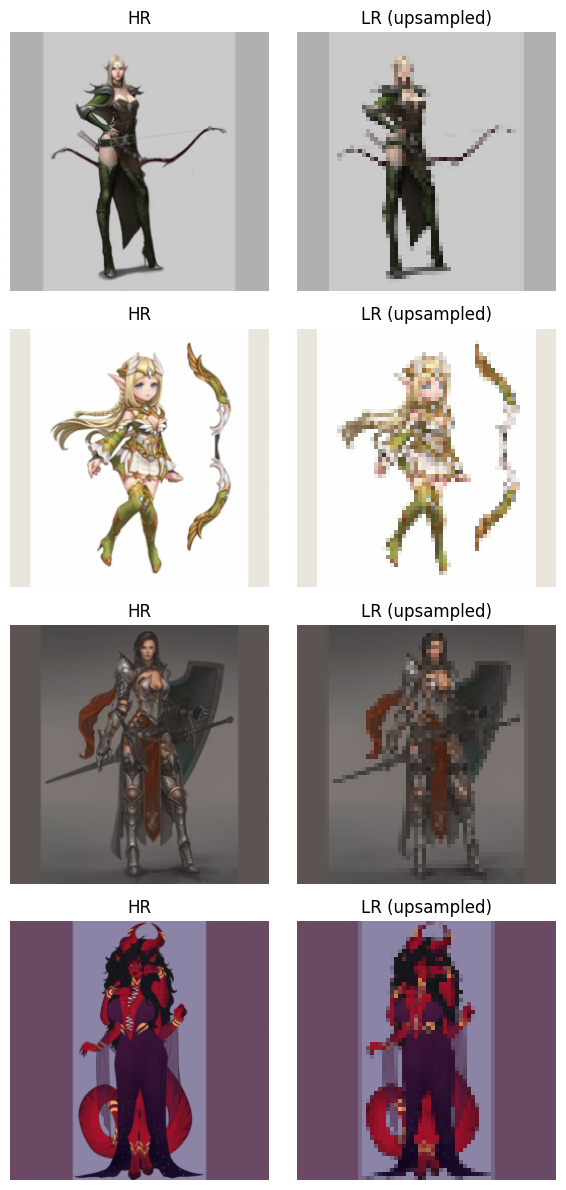

torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 64, 64])


In [5]:
# Scale to [-1, 1] (diffusion models usually expect this)
def scale_to_minus_one_to_one(x):
    return x * 2. - 1.


class CenterCropSquare:
    def __call__(self, img: Image.Image):
        w, h = img.size
        min_side = min(w, h)
        left = (w - min_side) // 2
        top = (h - min_side) // 2
        right = left + min_side
        bottom = top + min_side
        return img.crop((left, top, right, bottom))


class PadToSquare:
    def __init__(self, mode="both", color: tuple|None = None, size=None):
        assert mode in ['both', 'w', 'h'], "Mode must be 'both', 'width', or 'height'"
        self.mode = mode
        self.color = color
        self.size = size
    def __call__(self, img: Image.Image):
        w, h = img.size
        np_img = np.array(img)
        if not self.color:
            avg_color = tuple(np_img.mean(axis=(0, 1)).astype(int))
        clr = self.color or avg_color
        size = self.size or max(h,w)
        pad_w = size - w if (size > w and self.mode != 'h') else 0
        pad_h = size - h if (size> h and self.mode != 'w') else 0
        pad_l = pad_w // 2
        pad_r = pad_w - pad_l
        pad_t = pad_h // 2
        pad_b = pad_h - pad_t
        padding = (pad_l, pad_t, pad_r, pad_b) 
        return ImageOps.expand(img, padding, fill=clr)  # fill=0 for black padding


class SaliencyTopFractionSquareOrFull:
    def __init__(self, top_fraction=0.01, k=None):
        """
        top_fraction: fraction of image pixels to consider as top salient points

        For images with 231480 pixels, k=1000 seems good
        1000 / 231480
        """
        self.top_fraction = top_fraction
        self.saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
        self.k = k

    def __call__(self, img: Image.Image):
        img_cv = np.array(img.convert('RGB'))[..., ::-1]
        H, W = img_cv.shape[:2]
        side = min(H, W)

        # Compute saliency
        success, saliency_map = self.saliency.computeSaliency(img_cv)
        if not success:
            return img

        # Flatten saliency map and pick top fraction of pixels
        flat = saliency_map.flatten()
        k = self.k or max(1, int(self.top_fraction * flat.size))
        topk_idx = np.argpartition(flat, -k)[-k:]
        ys, xs = np.unravel_index(topk_idx, saliency_map.shape)

        # --- Attempt to fit all top-k points in a square of size `side` ---
        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()
        box_w = x_max - x_min + 1
        box_h = y_max - y_min + 1

        if box_w <= side and box_h <= side:
            # Center the square on the top-k bounding box
            cx = (x_min + x_max) // 2
            cy = (y_min + y_max) // 2
            left = cx - side // 2
            top = cy - side // 2
            # Clamp inside image
            left = max(0, min(left, W - side))
            top = max(0, min(top, H - side))
            cropped = img_cv[top:top+side, left:left+side]
            return Image.fromarray(cropped[..., ::-1])
        else:
            # Can't fit all points in the square → return full image
            return img


class CachedImageDataset(torch.utils.data.Dataset):
    """
    Useless if num_workers > 0 because the separate processes won't share cache.
    """
    def __init__(self, dataset):
        self.dataset = dataset
        self.cache = {}

    def __getitem__(self, idx):
        if idx not in self.cache:
            tns,lbl = self.dataset[idx]
            self.cache[idx] = (tns.detach().cpu(),lbl)
        return self.cache[idx]

    def __len__(self):
        return len(self.dataset)
    


class LRDataset(torch.utils.data.Dataset):
    def __init__(self, hr_dataset, lr_size=(LR, LR)):
        self.hr_dataset = hr_dataset
        self.lr_size = lr_size

    def __len__(self):
        return len(self.hr_dataset)

    def __getitem__(self, idx):
        hr, label = self.hr_dataset[idx]  # hr: (3,256,256)
        lr = TF.resize(hr, self.lr_size, antialias=True)  # (3,64,64)
        return lr,'img'

from torch.utils.data import Dataset
import torch.nn.functional as F

class LRHRDataset(Dataset):
    """
    Wraps an existing dataset that returns [3,H,H] tensors in [-1,1],
    and produces:
      - hr: [3, HR, HR]
      - lr: [3, LR, LR]
      #- cond_lr_up [3, HR, HR] (LR downsampled to LR_SIZE then upsampled)
    """
    def __init__(self, hr_dataset, lr_size=LR, hr_size=HR):
        super().__init__()
        self.hr_dataset = hr_dataset
        self.lr_size = lr_size
        self.hr_size = hr_size

    def __len__(self):
        return len(self.hr_dataset)

    def __getitem__(self, idx):
        hr_img, _ = self.hr_dataset[idx]  # [3,HR,HR]
        # Ensure it's [3,HR,HR]
        hr_img = F.interpolate(hr_img.unsqueeze(0), size=(self.hr_size, self.hr_size),
                               mode='bilinear', align_corners=False).squeeze(0)
        # Create LR then upscale
        lr_img = F.interpolate(hr_img.unsqueeze(0), size=(self.lr_size, self.lr_size),
                               mode='bilinear', align_corners=False)
        #cond_lr_up = F.interpolate(lr_img, size=(self.hr_size, self.hr_size),
        #                           mode='bilinear', align_corners=False).squeeze(0)
        #return hr_img, cond_lr_up
        return hr_img, lr_img.squeeze(0)


def get_datasets(data_root):
    hr_transform = transforms.Compose([
        # SaliencyTopFractionSquareOrFull(0.005), # dragon heads
        PadToSquare(),                        # crop to centered square
        #CenterCropSquare(),                        # crop to centered square
        transforms.Resize((HR, HR)),               # resize to 64x64
        transforms.ToTensor(),
        transforms.Lambda(scale_to_minus_one_to_one),
    ])
    hr_dataset = datasets.ImageFolder(root=data_root, transform=hr_transform)
    #hr_dataset = datasets.
    # transform_mnist = transforms.Compose([
    #     PadToSquare(size=256,color=(64,)),
    #     transforms.Resize((HR, HR)),
    #     transforms.ToTensor(),
    #     transforms.Lambda(scale_to_minus_one_to_one),
    #     transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # make 1-channel -> 3-channel
    # ])
    # hr_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)

    cached_hr_dataset = CachedImageDataset(hr_dataset)
    paired_dataset = LRHRDataset(cached_hr_dataset)
    lr_dataset = LRDataset(cached_hr_dataset)
    # LR Datset = 64x64 for training the initial model
    # paired_datset = 64x64 -> 256x256 dataset for SR3
    return(lr_dataset,paired_dataset)


def show_examples(data_root):
    train_dataset,paired_dataset = get_datasets(data_root)
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    examples, _ = next(iter(train_loader))  # grab a batch
    examples = examples[:8]  # just first 8

    fig, axes = plt.subplots(1, 8, figsize=(12, 2))
    for i, img in enumerate(examples):
        # Unscale back to [0,1] for display
        img_disp = (img * 0.5 + 0.5).permute(1, 2, 0).numpy()
        axes[i].imshow(img_disp)
        axes[i].axis("off")
    plt.show()
    print(len(train_dataset))
#show_examples(data_root)

import torchvision
def show_lr_hr_pairs(paired_dataset, num=4):
    #train_dataset,paired_dataset = get_datasets(data_root)
    loader = DataLoader(paired_dataset, batch_size=4, shuffle=True)

    fig, axes = plt.subplots(num, 2, figsize=(6, 3*num))
    for i in range(num):
        hr, lr_up = paired_dataset[i]

        # Convert from [-1,1] to [0,1] for visualization
        hr_vis = (hr * 0.5 + 0.5).clamp(0,1)
        lr_vis = (lr_up * 0.5 + 0.5).clamp(0,1)

        axes[i,1].imshow(torchvision.utils.make_grid(lr_vis).permute(1,2,0))
        axes[i,1].set_title("LR (upsampled)")
        axes[i,1].axis("off")

        axes[i,0].imshow(torchvision.utils.make_grid(hr_vis).permute(1,2,0))
        axes[i,0].set_title("HR")
        axes[i,0].axis("off")
    plt.tight_layout()
    plt.show()

    for hr_imgs, cond_lr_up in loader:
        print(hr_imgs.shape, cond_lr_up.shape)
        # Should print: torch.Size([4,3,128,128]) torch.Size([4,3,128,128])
        break
show_lr_hr_pairs(get_datasets(data_root)[1])



In [6]:
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader

# # Scale to [-1, 1] (diffusion models expect this)
# def scale_to_minus_one_to_one(x):
#     return x * 2. - 1.

# # Transform MNIST to 64x64 RGB (expand single channel to 3)
# transform_mnist = transforms.Compose([
#     transforms.Resize((64, 64)),
#     transforms.ToTensor(),
#     transforms.Lambda(scale_to_minus_one_to_one),
#     transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # make 1-channel -> 3-channel
# ])

# batch_size = 128
# train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# # Quick visualization
# examples, _ = next(iter(train_loader))
# examples = examples[:8]  # first 8 images
# import matplotlib.pyplot as plt
# import torchvision.utils as vutils

# grid = vutils.make_grid((examples * 0.5 + 0.5).clamp(0,1), nrow=8)
# plt.figure(figsize=(12,2))
# plt.imshow(grid.permute(1,2,0).cpu().numpy())
# plt.axis("off")
# plt.show()


## 4. Implement the Forward Diffusion Process

The forward process gradually adds Gaussian noise to the data over a fixed number of timesteps.

In [7]:
# Forward diffusion process

def illustrate_noising_process():
    device="cpu"
    T = 200  # Number of diffusion steps
    beta_start = 1e-4
    beta_end = 0.02
    betas = torch.linspace(beta_start, beta_end, T, device=device)
    alphas = 1. - betas
    alpha_bars = torch.cumprod(alphas, dim=0)

    def q_sample(x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alpha_bar = alpha_bars[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = (1 - alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
        return sqrt_alpha_bar * x_start + sqrt_one_minus_alpha_bar * noise

    # Visualize noisy images at different timesteps
    train_dataset,_ = get_datasets(data_root)
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    examples, _ = next(iter(train_loader))  # grab a batch
    examples = examples[:8]  # just first 8
    x = examples[:4].to(device)  # batch of clean images
    timesteps = torch.tensor([0, T//4, T//2, T-1], device=device)

    noisy_imgs = [q_sample(x, t.repeat(x.size(0)), noise=None) for t in timesteps]

    fig, axes = plt.subplots(1, 4, figsize=(5, 1))
    for i, img in enumerate(noisy_imgs):
        img_disp = img[0].detach().cpu()
        img_disp = (img_disp * 0.5 + 0.5).clamp(0, 1)   # unscale [-1,1] → [0,1]
        img_disp = img_disp.permute(1, 2, 0).numpy()   # CHW → HWC
        axes[i].imshow(img_disp)
        axes[i].set_title(f"t={timesteps[i].item()}")
        axes[i].axis('off')
    plt.show()
#illustrate_noising_process()


## Checkpoint stuff

In [8]:
import torch
import os

import torch
import os
from datetime import datetime

def save_checkpoint(model, optimizer, epoch, loss, path=None, tag = ""):
    checkpoint = {
        "epoch": epoch,
        "loss": loss,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "model_class": model.__class__.__name__,
        "model_repr": str(model),  # optional: full repr for reference
    }

    if path is None:
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        cls_name = model.__class__.__name__
        path = f"checkpoints/{cls_name}_{timestamp}_{tag}.pth"

    dir_name = os.path.dirname(path)
    if dir_name != "":
        os.makedirs(dir_name, exist_ok=True)

    torch.save(checkpoint, path)
    print(f"✅ Saved checkpoint: {path}")
    return path

def load_checkpoint(model, optimizer, path, map_location=None):
    checkpoint = torch.load(path, map_location=map_location or "cpu")
    model.load_state_dict(checkpoint["model_state_dict"])
    if optimizer:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    print(f"🔄 Loaded checkpoint from {path}")
    print(f"    Epoch: {checkpoint.get('epoch', '?')}, Loss: {checkpoint.get('loss', '?')}")
    print(f"    Model class: {checkpoint.get('model_class', '?')}")
    return model, optimizer, checkpoint




## 6. Elucidated Diffusion Model (EDM) Implementation

This section implements the EDM as described in the paper (2206.00364v2.pdf), including its unique noise schedule, loss weighting, and sampling procedure.

### 6a. EDM loss and schedule functions.

In [9]:
# EDM noise schedule, loss weighting, and sampling procedure
# EDM parameters from NVIDIA's reference
P_mean = -1.2  # Mean of log-normal distribution for sigma sampling
P_std = 1.2    # Std of log-normal distribution for sigma sampling
sigma_data = 0.5  # Data standard deviation
sigma_min = 0.002
sigma_max = 80
rho = 7

# EDM noise schedule (sampling)
def edm_sigma_schedule(t):
    return (sigma_max ** (1/rho) + t * (sigma_min ** (1/rho) - sigma_max ** (1/rho))) ** rho

# EDM loss weighting - CORRECTED according to NVIDIA's implementation
# weight = (σ² + σ_data²) / (σ × σ_data)²
def edm_loss_weight(sigma, sigma_data=sigma_data):
    return (sigma ** 2 + sigma_data ** 2) / (sigma * sigma_data) ** 2


if show_edm_schedule:=False:
    # Example: plot the EDM noise schedule
    ts = torch.linspace(0, 1, 100)
    sigmas = edm_sigma_schedule(ts)
    plt.plot(ts.numpy(), sigmas.numpy())
    plt.xlabel('t')
    plt.ylabel('sigma(t)')
    plt.title('EDM Noise Schedule')
    plt.show()

### 6b. EDM Sampling / Reconstruction

In [10]:
# EDM sampling procedure - Following NVIDIA's edm_sampler (Algorithm 2)
def edm_ancestral_sampling(model, num_steps=18, batch_size=8, img_shape=(1, 28, 28)):
    device = next(model.parameters()).device
    
    # Initialize noise
    x_next = torch.randn((batch_size,) + img_shape, device=device)
    
    # Time step schedule (matching NVIDIA's implementation)
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)
    t_steps = (sigma_max ** (1/rho) + step_indices / (num_steps - 1) * 
               (sigma_min ** (1/rho) - sigma_max ** (1/rho))) ** rho
    t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])])  # t_N = 0
    
    # Initialize with first noise level
    x_next = x_next * t_steps[0]
    
    # Main sampling loop (Heun's method)
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):
        x_cur = x_next
        
        # Preconditioning coefficients for current timestep
        sigma = t_cur.float()
        c_skip = sigma_data ** 2 / (sigma ** 2 + sigma_data ** 2)
        c_out = sigma * sigma_data / (sigma ** 2 + sigma_data ** 2).sqrt()
        c_in = 1 / (sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4
        
        # Euler step
        F_x = model(c_in * x_cur, c_noise.expand(batch_size))
        denoised = c_skip * x_cur + c_out * F_x
        d_cur = (x_cur - denoised) / t_cur
        x_next = x_cur + (t_next - t_cur) * d_cur
        
        # Apply 2nd order correction (Heun's method) - except for last step
        if i < num_steps - 1:
            # Preconditioning coefficients for next timestep
            sigma_next = t_next.float()
            c_skip_next = sigma_data ** 2 / (sigma_next ** 2 + sigma_data ** 2)
            c_out_next = sigma_next * sigma_data / (sigma_next ** 2 + sigma_data ** 2).sqrt()
            c_in_next = 1 / (sigma_data ** 2 + sigma_next ** 2).sqrt()
            c_noise_next = sigma_next.log() / 4
            
            F_x_next = model(c_in_next * x_next, c_noise_next.expand(batch_size))
            denoised_next = c_skip_next * x_next + c_out_next * F_x_next
            d_prime = (x_next - denoised_next) / t_next
            x_next = x_cur + (t_next - t_cur) * (0.5 * d_cur + 0.5 * d_prime)
    
    return x_next.to("cpu")

In [11]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def generate_images(model_edm, num_steps=15, batch_size=20, img_shape = (3,64,64)):
    to_pil = transforms.ToPILImage()
    with torch.no_grad():
        samples = edm_ancestral_sampling(model_edm, num_steps=num_steps, batch_size=batch_size, img_shape=(3, 64, 64)).cpu()
        samples = (samples + 1) / 2  # scale from [-1,1] to [0,1]
        samples = samples.clamp(0, 1)
        pil_images = [to_pil(img) for img in samples]
    return pil_images

def pil_to_data_url(pil_img):
    buffered = BytesIO()
    pil_img.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return f"data:image/png;base64,{img_str}"

def html_for_images(pil_images, min_height=64, title="Hi"):
    data_urls = [pil_to_data_url(img) for img in pil_images]
    html = f"""
    <h2>{title}</h2>
    <div style="display: flex; flex-wrap: wrap; gap: 2px;">
    """
    for url in data_urls:
        html += f"""
        <div style="flex: 0 0 auto;">
            <img src="{url}" style="min-width: {min_height}px;"/>
        </div>
        """
    html += "</div>"
    return html

def sample_html(model, batch_size=12, img_shape=(3,64,64), num_steps=36, title="EDM Samples",min_height=128):
    imgs = generate_images(model_edm=model, batch_size=batch_size, img_shape=img_shape, num_steps=16)
    h = html_for_images(imgs, title=title, min_height=min_height)
    return h


# 6c. EDM Training Loop 

In [12]:
# EDM training loop - CORRECTED with proper preconditioning coefficients
# Following NVIDIA's EDMPrecond implementation exactly

def train_a_batch(model_edm, optimizer_edm, batch):
 
        x = batch.to(device)
        
        # Log-normal sigma sampling (as in NVIDIA's implementation)
        rnd_normal = torch.randn([x.shape[0], 1, 1, 1], device=device)
        sigma = (rnd_normal * P_std + P_mean).exp()
        
        # Preconditioning coefficients (from NVIDIA's EDMPrecond)
        c_skip = sigma_data ** 2 / (sigma ** 2 + sigma_data ** 2)
        c_out = sigma * sigma_data / (sigma ** 2 + sigma_data ** 2).sqrt()
        c_in = 1 / (sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4
        
        # Add noise: y_noisy = x + σ·n where n ~ N(0,I)
        noise = torch.randn_like(x) * sigma
        y_noisy = x + noise
        
        # Model prediction: F_x = net(c_in * y_noisy, c_noise)
        c_noise_input = c_noise.view(x.shape[0])
        F_x = model_edm(c_in * y_noisy, c_noise_input)
        
        # Preconditioning: D_x = c_skip * y_noisy + c_out * F_x
        D_x = c_skip * y_noisy + c_out * F_x
        
        # Loss weight: λ(σ) = (σ² + σ_data²) / (σ·σ_data)²
        weight = edm_loss_weight(sigma.squeeze(), sigma_data).view(-1, 1, 1, 1)
        
        # Loss: weighted MSE between preconditioning output and clean image
        loss = (weight * (D_x - x) ** 2).mean()
        
        optimizer_edm.zero_grad()
        loss.backward()
        optimizer_edm.step()
        return loss.item()


In [13]:
def train_some(data_root):
    model_edm = UNet128(use_attention=True).to(device)
    optimizer_edm = optim.Adam(model_edm.parameters(), lr=2e-4)
    train_dataset,_ = get_datasets(data_root)
    batch_size = 128
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    if resume:=True:
        load_checkpoint(model=model_edm, optimizer=optimizer_edm, path=good_weights)
    
    t0 = time.time()
    next_display_time = t0
    display_interval = 60
    next_display_time = time.time()
    checkpoint_interval = 60 * 60
    next_checkpoint_time = time.time() + checkpoint_interval
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    path = f"outputs/{experiment_name}_{timestamp}.html"
    os.makedirs("outputs", exist_ok=True)
    with open("/tmp/training_running.txt","w"):
        pass
    for epoch in range(999999):
        pbar = tqdm(train_loader)
        if not os.path.exists("/tmp/training_running.txt"):
            break
        for x, _ in pbar:
            if not os.path.exists("/tmp/training_running.txt"):
                break
            loss = train_a_batch(model_edm,optimizer_edm,x)
            pbar.set_description(f"EDM Epoch {epoch+1} Loss: {loss:.4f}")
            if time.time() > next_checkpoint_time:
                save_checkpoint(model_edm, optimizer_edm, epoch, loss, tag=experiment_name)
                next_checkpoint_time = time.time() + checkpoint_interval
            if time.time() > next_display_time:
                next_display_time += display_interval
                dt = time.strftime('%H:%M:%S', time.gmtime(time.time() - t0))
                h = sample_html(model_edm,title=f"EDM at {dt} loss {loss:.4f} ({timestamp})")
                with open(path,"a") as f:
                    f.write(h)
                ipd.clear_output(wait=True)
                ipd.display(ipd.HTML(h))
    path = save_checkpoint(model_edm, optimizer_edm, epoch, loss, tag=experiment_name)
    del model_edm,optimizer_edm
    return path

#train_some(data_root)
        

In [14]:
import objgraph
import torch
import gc

if debug_leaking_tensors := False:
    gc.collect()
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    gc.collect()
    torch.cuda.empty_cache()
    print(torch.cuda.memory_summary()) 


    # Find one lingering tensor
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            print(f"Found tensor: {type(obj)}, size: {obj.size()}")
            result = objgraph.show_backrefs([obj], max_depth=3)
            ipd.display(result)
            break

    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                print(type(obj), obj.size())
        except:
            pass


## Inferrence

In [15]:
#good_weights = "checkpoints/UNet128_2025-09-08_17-57-30_cats_and_dogs.pth"
#good_weights = "checkpoints/UNet128_2025-09-09_06-38-40_fantasy.pth"
#load_checkpoint(model_edm, optimizer_edm, good_weights)

def generate_html_examples(cp="checkpoints/UNet128_2025-09-12_19-47-15_dragon.pth"):
    with torch.no_grad():
        model_edm = UNet128(use_attention=True).to(device)
        optimizer_edm = None
        load_checkpoint(model_edm, optimizer_edm, cp)
        h = sample_html(model_edm,title=f"Samples from {cp}",min_height=256, batch_size=24) # leaks 
        ipd.display(ipd.HTML(h))
        model_edm.to('cpu')
        
#generate_html_examples()


## Maybe free some memory?

In [16]:
torch.cuda.empty_cache()
gc.collect()
print(torch.cuda.memory_summary()) 


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [17]:
torch.cuda.empty_cache()
import gc
#del model_edm
#del optimizer_edm
gc.collect()
torch.cuda.empty_cache()


In [18]:
# import torch
# import gc
# for obj in gc.get_objects():
#     try:
#         if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
#             print(type(obj), obj.size())
#     except:
#         pass

## SR3

torch.Size([3, 256, 256]) torch.Size([3, 64, 64])


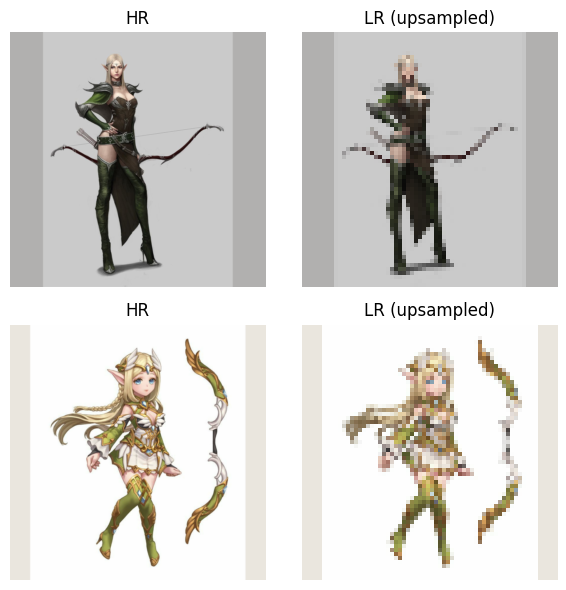

torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 64, 64])


In [19]:
lr_dataset, paired_dataset = get_datasets(data_root)
l,h = paired_dataset[0]
print(l.shape,h.shape)
show_lr_hr_pairs(paired_dataset,num=2)

def sr_to_pil(sr_tensor):
    """sr_tensor: [3,H,W] or [B,3,H,W] float in [-1,1] returns: PIL Image (RGB)"""
    if sr_tensor.dim() == 4:
        sr_tensor = sr_tensor[0] # first in batch
    sr_tensor = ((sr_tensor.clamp(-1, 1) + 1) * 127.5).to(torch.uint8)
    sr_np = sr_tensor.permute(1,2,0).cpu().numpy()
    return Image.fromarray(sr_np)

In [20]:
if debug:= False:
    num_epochs = 3
    train_dataset,paired_dataset = get_datasets(data_root)
    train_loader = DataLoader(paired_dataset, batch_size=4, shuffle=False)
    [x.shape for x in next(iter(train_loader))]
    import torch

    # Grab one batch
    hr, lr = next(iter(train_loader))  # expects (HR, LR)

    def describe(name, x):
        print(f"{name}: shape={tuple(x.shape)}, "
            f"min={x.min().item():.3f}, max={x.max().item():.3f}, "
            f"mean={x.mean().item():.3f}")

    describe("HR", hr)
    describe("LR", lr)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# --- Helper: sinusoidal timestep embedding ---
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):  # t: [B] in [0,1] float
        device = t.device
        half_dim = self.dim // 2
        freqs = torch.exp(
            torch.arange(half_dim, device=device) * -(math.log(10000) / (half_dim - 1))
        )
        emb = t[:, None] * freqs[None, :]   # [B, half_dim]
        emb = torch.cat([emb.sin(), emb.cos()], dim=-1)  # [B, dim]
        return emb

# --- Basic residual block ---
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.block1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.block2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        # x: [B, C, H, W], t_emb: [B, time_emb_dim]
        h = F.silu(self.block1(x))
        # Add time embedding as bias
        h += self.time_mlp(t_emb)[:, :, None, None]
        h = F.silu(self.block2(h))
        return h + self.res_conv(x)

# --- U-Net core ---
class UNetSR3(nn.Module):
    def __init__(self, in_ch=6, out_ch=3, base_ch=64, time_emb_dim=128):
        super().__init__()
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )

        # Encoder
        self.enc1 = ResBlock(in_ch, base_ch, time_emb_dim)
        self.enc2 = ResBlock(base_ch, base_ch * 2, time_emb_dim)
        self.enc3 = ResBlock(base_ch * 2, base_ch * 4, time_emb_dim)

        # Bottleneck
        self.mid = ResBlock(base_ch * 4, base_ch * 4, time_emb_dim)

        # Decoder
        self.dec3 = ResBlock(base_ch * 4 + base_ch * 4, base_ch * 2, time_emb_dim)
        self.dec2 = ResBlock(base_ch * 2 + base_ch * 2, base_ch, time_emb_dim)
        self.dec1 = ResBlock(base_ch + base_ch, base_ch, time_emb_dim)

        # Final output: predict noise (same shape as HR image)
        self.out_conv = nn.Conv2d(base_ch, out_ch, 1)

        self.down = nn.AvgPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def forward(self, x, t):
        """
        x: [B, 6, 256, 256] = concat([x_noisy, lr_upsampled])
        t: [B] float timesteps normalized to [0,1]
        """
        # ---- time embedding ----
        t_emb = self.time_emb(t)  # [B, time_emb_dim]

        # ---- down path ----
        e1 = self.enc1(x, t_emb)           # [B, 64, 256, 256]
        e2 = self.enc2(self.down(e1), t_emb)  # [B, 128, 128, 128]
        e3 = self.enc3(self.down(e2), t_emb)  # [B, 256, 64, 64]

        # ---- bottleneck ----
        m = self.mid(e3, t_emb)             # [B, 256, 64, 64]

        # ---- up path ----
        #d3 = self.dec3(torch.cat([self.up(m), e3], dim=1), t_emb)  # [B, 128, 64, 64]
        #d2 = self.dec2(torch.cat([self.up(d3), e2], dim=1), t_emb) # [B, 64, 128, 128]
        #d1 = self.dec1(torch.cat([self.up(d2), e1], dim=1), t_emb) # [B, 64, 256, 256]
        # ---- up path (fixed spatial alignment) ----
        d3 = self.dec3(torch.cat([m, e3], dim=1), t_emb)            # [B, 128, 64, 64]
        d3_up = self.up(d3)                                         # [B, 128, 128, 128]

        d2 = self.dec2(torch.cat([d3_up, e2], dim=1), t_emb)         # [B, 64, 128, 128]
        d2_up = self.up(d2)                                         # [B, 64, 256, 256]

        d1 = self.dec1(torch.cat([d2_up, e1], dim=1), t_emb)         # [B, 64, 256, 256]

        return self.out_conv(d1)  # [B, 3, 256, 256]


In [22]:
# Sanity check the model's inpus and outputs are as expected
B = 4
hrimg = torch.randn(B, 3, 256, 256).cuda()
lrimg = torch.randn(B, 3, 64, 64).cuda()
t = torch.rand(B).cuda()

lr_up = F.interpolate(lrimg, size=(256,256), mode='bilinear', align_corners=False)
x_noisy = torch.randn_like(hrimg)
x_in = torch.cat([x_noisy, lr_up], dim=1).cuda()

model = UNetSR3().cuda()
with torch.no_grad():
    out = model(x_in, t)
print("Output:", out.shape)  # should be [4, 3, 256, 256]


Output: torch.Size([4, 3, 256, 256])


In [23]:
# --- Initialize model ---
model = UNetSR3().to(device)
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [24]:
# TODO - re-merge with the one above
def edm_ancestral_sampling(model, lr_up, num_steps=54, batch_size=8, img_shape=(1, 28, 28)):
    device = next(model.parameters()).device
    
    # Initialize noise
    x_next = torch.randn((batch_size,) + img_shape, device=device)
    
    # Time step schedule (matching NVIDIA's implementation)
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)
    t_steps = (sigma_max ** (1/rho) + step_indices / (num_steps - 1) * 
               (sigma_min ** (1/rho) - sigma_max ** (1/rho))) ** rho
    t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])])  # t_N = 0
    
    # Initialize with first noise level
    x_next = x_next * t_steps[0]
    
    # Main sampling loop (Heun's method)
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):
        x_cur = x_next
        
        # Preconditioning coefficients for current timestep
        sigma = t_cur.float()
        c_skip = sigma_data ** 2 / (sigma ** 2 + sigma_data ** 2)
        c_out = sigma * sigma_data / (sigma ** 2 + sigma_data ** 2).sqrt()
        c_in = 1 / (sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4
        
        # Euler step
        this_models_input = torch.cat([c_in*x_cur, lr_up], dim=1).cuda()
        #F_x = model(c_in * x_cur, c_noise.expand(batch_size))
        F_x = model(this_models_input, c_noise.expand(batch_size))
        denoised = c_skip * x_cur + c_out * F_x
        d_cur = (x_cur - denoised) / t_cur
        x_next = x_cur + (t_next - t_cur) * d_cur
        
        # Apply 2nd order correction (Heun's method) - except for last step
        if i < num_steps - 1:
            # Preconditioning coefficients for next timestep
            sigma_next = t_next.float()
            c_skip_next = sigma_data ** 2 / (sigma_next ** 2 + sigma_data ** 2)
            c_out_next = sigma_next * sigma_data / (sigma_next ** 2 + sigma_data ** 2).sqrt()
            c_in_next = 1 / (sigma_data ** 2 + sigma_next ** 2).sqrt()
            c_noise_next = sigma_next.log() / 4
            
            #F_x_next = model(c_in_next * x_next, c_noise_next.expand(batch_size))
            this_models_input = torch.cat([c_in_next * x_next, lr_up], dim=1).cuda()
            F_x_next = model(this_models_input, c_noise_next.expand(batch_size))


            denoised_next = c_skip_next * x_next + c_out_next * F_x_next
            d_prime = (x_next - denoised_next) / t_next
            x_next = x_cur + (t_next - t_cur) * (0.5 * d_cur + 0.5 * d_prime)
    
    return x_next.to("cpu")

In [25]:
# sanity check shapes
with torch.no_grad():
    edm_ancestral_sampling(model,lr_up,batch_size=4,img_shape=(3,256,256))

In [26]:
# EDM training loop - CORRECTED with proper preconditioning coefficients
# Following NVIDIA's EDMPrecond implementation exactly

def train_a_batch(model_edm, optimizer_edm, batch):
 
        x = batch
        hr_256, lr_64 = x
        # Move to device
        hr_256 = hr_256.to(device)          # [B, 3, 256, 256]
        lr_64 = lr_64.to(device)            # [B, 3, 64, 64]

        x = hr_256
        # Log-normal sigma sampling (as in NVIDIA's implementation)
        rnd_normal = torch.randn([x.shape[0], 1, 1, 1], device=device)
        sigma = (rnd_normal * P_std + P_mean).exp()
        
        # Preconditioning coefficients (from NVIDIA's EDMPrecond)
        c_skip = sigma_data ** 2 / (sigma ** 2 + sigma_data ** 2)
        c_out = sigma * sigma_data / (sigma ** 2 + sigma_data ** 2).sqrt()
        c_in = 1 / (sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4
        
        # Add noise: y_noisy = x + σ·n where n ~ N(0,I)
        noise = torch.randn_like(x) * sigma
        y_noisy = x + noise
        
        # Model prediction: F_x = net(c_in * y_noisy, c_noise)
        c_noise_input = c_noise.view(x.shape[0])

# here

        # Upsample LR to HR resolution
        lr_up = F.interpolate(lr_64, size=hr_256.shape[-2:], mode='bilinear', align_corners=False)
        # Expected shape: [B, 3, 256, 256]

        ## Sample timestep t for each item in batch
        #b = hr_256.shape[0]
        
        # Concatenate noisy HR + upsampled LR for conditioning
        x_input = torch.cat([y_noisy, lr_up], dim=1)  # [B, 6, 256, 256]

        # --- Optional sanity assertions ---
        assert x_input.shape[1] == 6, f"Expected 6 channels, got {x_input.shape[1]}"
        assert hr_256.shape == noise.shape, "HR and noise shapes must match"


        this_models_input = torch.cat([c_in * y_noisy, lr_up], dim=1).cuda()
#            F_x_next = model(this_models_input, c_noise_next.expand(batch_size))

        F_x = model_edm(this_models_input, c_noise_input)
        #F_x = model_edm(c_in * y_noisy, c_noise_input)
# end of here
        # Preconditioning: D_x = c_skip * y_noisy + c_out * F_x
        D_x = c_skip * y_noisy + c_out * F_x
        
        # Loss weight: λ(σ) = (σ² + σ_data²) / (σ·σ_data)²
        weight = edm_loss_weight(sigma.squeeze(), sigma_data).view(-1, 1, 1, 1)
        
        # Loss: weighted MSE between preconditioning output and clean image
        loss = (weight * (D_x - x) ** 2).mean()
        
        optimizer_edm.zero_grad()
        loss.backward()
        optimizer_edm.step()
        return loss.item()


In [27]:
train_loader = DataLoader(paired_dataset, batch_size=4, shuffle=False)
batch = next(iter(train_loader))
train_a_batch(model, optimizer, batch)


1.383345603942871

In [28]:
train_a_batch(model, optimizer, batch)


1.2610784769058228

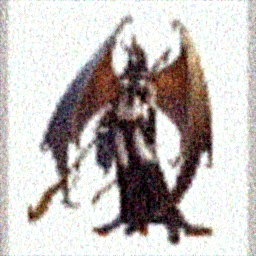

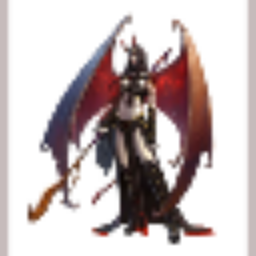

EDM Epoch 1 Loss: 0.2964:   0%|          | 8/3204 [00:18<2:01:00,  2.27s/it]


KeyboardInterrupt: 

In [31]:
def train_some_sr(model, optimizer,data_root):
    model_edm = model #UNet128(use_attention=True).to(device)
    optimizer_edm = optimizer# optim.Adam(model_edm.parameters(), lr=2e-4)
    train_dataset,_ = get_datasets(data_root)
    batch_size = 128
    train_dataset,paired_dataset = get_datasets(data_root)
    train_loader = DataLoader(paired_dataset, batch_size=4, shuffle=False)
    #train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    if resume:=False:
        load_checkpoint(model=model_edm, optimizer=optimizer_edm, path=good_weights)
    
    t0 = time.time()
    next_display_time = t0 + 999999
    display_interval = 60
    next_display_time = time.time()
    checkpoint_interval = 60 * 60
    next_checkpoint_time = time.time() + checkpoint_interval
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    path = f"outputs/SR_{experiment_name}_{timestamp}.html"
    os.makedirs("outputs", exist_ok=True)
    with open("/tmp/training_running.txt","w"):
        pass
    for epoch in range(999999):
        pbar = tqdm(train_loader)
        if not os.path.exists("/tmp/training_running.txt"):
            break
        for x in pbar:
            hr,lr = x
            if not os.path.exists("/tmp/training_running.txt"):
                break
            loss = train_a_batch(model_edm,optimizer_edm,x)
            pbar.set_description(f"EDM Epoch {epoch+1} Loss: {loss:.4f}")
            #if time.time() > next_checkpoint_time:
            #    save_checkpoint(model_edm, optimizer_edm, epoch, loss, tag=experiment_name)
            #   next_checkpoint_time = time.time() + checkpoint_interval
            if time.time() > next_display_time:
                with torch.no_grad():
                    lr_up = F.interpolate(lr, size=hr.shape[-2:], mode='bilinear', align_corners=False).cuda()
                    out = edm_ancestral_sampling(model, lr_up, num_steps=18,batch_size=4,img_shape=(3,256,256))
                    print(out.shape)
                    ipd.clear_output(wait=True)
                    ipd.display(sr_to_pil(out[0]))
                    ipd.display(sr_to_pil(lr_up[0]))
            #     next_display_time += display_interval
            #     dt = time.strftime('%H:%M:%S', time.gmtime(time.time() - t0))
            #     h = sample_html(model_edm,title=f"EDM at {dt} loss {loss:.4f} ({timestamp})")
            #     with open(path,"a") as f:
            #         f.write(h)
            #     ipd.clear_output(wait=True)
            #     ipd.display(ipd.HTML(h))
   # path = save_checkpoint(model_edm, optimizer_edm, epoch, loss, tag=experiment_name)
    del model_edm,optimizer_edm
    return path

#train_some(data_root)
train_some_sr(model, optimizer,data_root)

In [ ]:
raise Exception("everything below is obsolete")

Exception: everything below is obsolete

In [ ]:
import torch
import torch.nn.functional as F

# --- Hyperparameters ---
timesteps = 1000
device = 'cuda'
lr = 1e-4
batch_size = 4
next_display_time = time.time()

# Assuming you already have:
# dataloader: yields (hr_256, lr_64)
# betas, alphas, alphas_cumprod: 1D tensors for diffusion schedule
def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)
timesteps = 1000
betas = linear_beta_schedule(timesteps)
# Move schedule tensors to device
betas = betas.to(device)
alphas = (1 - betas).to(device)
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)

# --- Define q_sample ---
def q_sample(x_start, t, noise):
    """
    Add noise to HR image at timestep t
    x_start: [B, 3, 256, 256]
    t: [B] long
    noise: [B, 3, 256, 256]
    """
    sqrt_alpha_cumprod = torch.sqrt(alphas_cumprod[t])[:, None, None, None]
    sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - alphas_cumprod[t])[:, None, None, None]
    return sqrt_alpha_cumprod * x_start + sqrt_one_minus_alpha_cumprod * noise



# --- Training loop ---
num_epochs = 5  # small for testing

for epoch in range(num_epochs):
    pbar = tqdm(train_loader)
    for hr_256, lr_64 in pbar:
        # Move to device
        hr_256 = hr_256.to(device)          # [B, 3, 256, 256]
        lr_64 = lr_64.to(device)            # [B, 3, 64, 64]

        # Upsample LR to HR resolution
        lr_up = F.interpolate(lr_64, size=hr_256.shape[-2:], mode='bilinear', align_corners=False)
        # Expected shape: [B, 3, 256, 256]

        # Sample timestep t for each item in batch
        b = hr_256.shape[0]
        t = torch.randint(0, timesteps, (b,), device=device).long()  # [B]

        # Sample Gaussian noise
        noise = torch.randn_like(hr_256)  # [B, 3, 256, 256]

        # Forward diffusion (add noise to HR image)
        x_noisy = q_sample(hr_256, t, noise)  # [B, 3, 256, 256]

        # Concatenate noisy HR + upsampled LR for conditioning
        x_input = torch.cat([x_noisy, lr_up], dim=1)  # [B, 6, 256, 256]

        # --- Optional sanity assertions ---
        assert x_input.shape[1] == 6, f"Expected 6 channels, got {x_input.shape[1]}"
        assert hr_256.shape == noise.shape, "HR and noise shapes must match"

        # Predict noise
        t_norm = t.float() / timesteps
        noise_pred = model(x_input, t_norm)  # [B, 3, 256, 256]

        # Compute loss
        loss = F.mse_loss(noise_pred, noise)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Epoch {epoch+1} Loss: {loss.item():.4f}")
        if time.time() > next_display_time:
            next_display_time = time.time() + 10
            with torch.inference_mode():
                    ipd.clear_output(wait=True)
                    def centercrop(img):
                        return img.crop((128 - 28, 128 - 28, 128 + 28, 128+28))
                    imgs = [
                        sr_to_pil(lr_up),
                        sr_to_pil(x_noisy),
                        sr_to_pil(noise_pred[0]),
                        sr_to_pil(noise_pred[0] - noise[0]),
                        sr_to_pil(lr_up + noise_pred[0] - noise[0])
                    ]
                    imgs = [centercrop(i) for i in imgs]
                    fig, axes = plt.subplots(1, 5, figsize=(16, 4))
                    for ax, img in zip(axes, imgs):
                        ax.imshow(img)
                        ax.axis('off')
                    plt.show()
                                

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")


  0%|          | 0/15000 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 5.78 GiB of which 33.88 MiB is free. Including non-PyTorch memory, this process has 5.20 GiB memory in use. Of the allocated memory 5.06 GiB is allocated by PyTorch, and 25.15 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
with torch.inference_mode():
        ipd.clear_output(wait=True)
        def centercrop(img):
            return img.crop((128 - 28, 128 - 28, 128 + 28, 128+28))
        tmp=x_noisy - lr_up
        imgs = [
            sr_to_pil(lr_up),
            sr_to_pil(x_noisy),
            sr_to_pil(tmp - noise[0]),
            sr_to_pil(noise_pred[0]),
            sr_to_pil(noise_pred[0] - noise[0]),
            sr_to_pil(lr_up + noise_pred[0] - noise[0]),
            sr_to_pil(lr_up + tmp - noise[0])
        ]
        imgs = [centercrop(i) for i in imgs]
        fig, axes = plt.subplots(1, 10, figsize=(16, 4))
        for ax, img in zip(axes, imgs):
            ax.imshow(img)
            ax.axis('off')
        plt.show()

TypeError: Cannot handle this data type: (1, 1, 6), |u1

In [ ]:
@torch.no_grad()
def p_sample(model, x, t, t_index, cond_lr, betas, alphas_cumprod):
    """
    Single diffusion step.
    x: current noisy HR image [B, 3, 256, 256]
    t: tensor of current timestep [B]
    cond_lr: upsampled LR image [B, 3, 256, 256]
    """
    # Concatenate noisy HR + LR conditioning
    x_input = torch.cat([x, cond_lr], dim=1)  # [B, 6, 256, 256]

    # Predict noise
    t_norm = t.float() / timesteps
    noise_pred = model(x_input, t_norm)

    # Compute coefficients
    alpha_t = alphas_cumprod[t][:, None, None, None]
    sqrt_alpha = torch.sqrt(alpha_t)
    sqrt_one_minus_alpha = torch.sqrt(1 - alpha_t)
    beta_t = 1 - alpha_t  # simplified

    # Predict denoised HR
    pred_x0 = (x - sqrt_one_minus_alpha * noise_pred) / sqrt_alpha

    # Posterior mean
    mean = sqrt_alpha * pred_x0 + sqrt_one_minus_alpha * noise_pred

    # Sample noise if not final step
    if t_index > 0:
        noise = torch.randn_like(x)
    else:
        noise = torch.zeros_like(x)

    return mean + torch.sqrt(beta_t) * noise


@torch.no_grad()
def sample_sr(model, cond_lr, timesteps=1000):
    """
    cond_lr: [B, 3, 64, 64] low-res image
    returns: [B, 3, 256, 256] super-resolved HR image
    """
    device = cond_lr.device
    b = cond_lr.size(0)

    # Start from pure noise at HR size
    x = torch.randn(b, 3, 256, 256, device=device)

    # Upsample LR for conditioning
    lr_up = F.interpolate(cond_lr, size=(256,256), mode='bilinear', align_corners=False)

    for i in reversed(range(timesteps)):
        t = torch.full((b,), i, device=device, dtype=torch.long)
        x = p_sample(model, x, t, i, lr_up, betas, alphas_cumprod)

    return x.clamp(-1, 1)  # keep in [-1,1] range


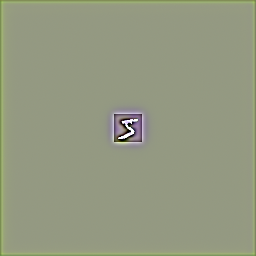

In [ ]:
### Sanity Check one step of samplng. 

# Take one HR-LR pair
dataloader = train_loader
hr_sample, lr_sample = next(iter(dataloader))
hr_sample = hr_sample.cuda()
lr_sample = lr_sample.cuda()

# Add only small noise
noise = torch.randn_like(hr_sample) * 0.1
t = torch.zeros(hr_sample.size(0), dtype=torch.long).cuda()  # timestep 0

x_noisy = q_sample(hr_sample, t, noise)
lr_up = F.interpolate(lr_sample, size=(256,256), mode='bilinear', align_corners=False)
x_input = torch.cat([x_noisy, lr_up], dim=1)
with torch.no_grad():
    out = model(x_input, t.float() / timesteps)

# Show output
img = sr_to_pil(out)
img

In [ ]:
### Sanity Check one step of samplng. 

# Take one HR-LR pair
dataloader = train_loader
hr_sample, lr_sample = next(iter(dataloader))
hr_sample = hr_sample.cuda()
lr_sample = lr_sample.cuda()

# Add only small noise
noise = torch.randn_like(hr_sample) * 0.1
t = torch.zeros(hr_sample.size(0), dtype=torch.long).cuda()  # timestep 0

#x_noisy = q_sample(hr_sample, t, noise)
lr_up = F.interpolate(lr_sample, size=(256,256), mode='bilinear', align_corners=False)
x_noisy = q_sample(lr_up,t,noise)
x_input = torch.cat([x_noisy, lr_up], dim=1)
with torch.no_grad():
    out = model(x_input, t.float() / timesteps)

# Show output
img = sr_to_pil(out)
img

NameError: name 'train_loader' is not defined

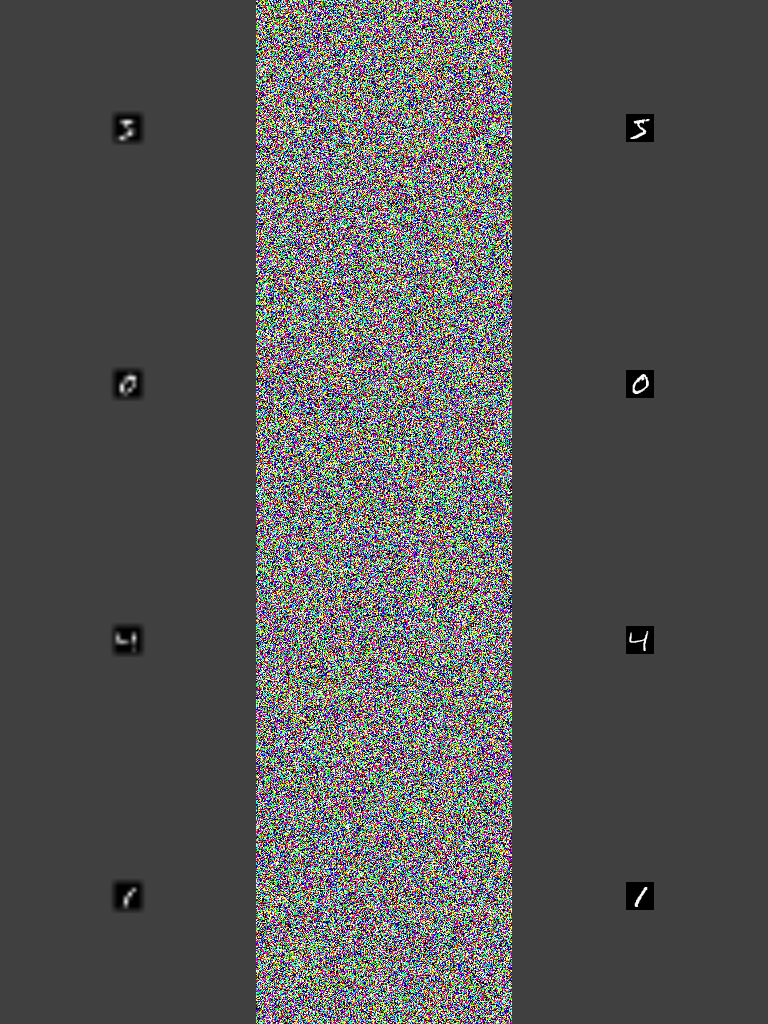

In [ ]:
model.eval()
for hr_256, lr_64 in train_loader:
    sr_out = sample_sr(model, lr_64.cuda())  # [B, 3, 256, 256]
    break

#from torchvision.utils import save_image
#save_image((sr_out + 1) / 2, 'sr_sample.png')  # map [-1,1] → [0,1] for saving


from torchvision.utils import make_grid
import torch
from PIL import Image

def compare_lr_sr_hr(lr, sr, hr=None, save_path=None):
    """
    lr:  [B, 3, 64, 64]   low-res input
    sr:  [B, 3, 256, 256] super-res output
    hr:  [B, 3, 256, 256] optional ground-truth high-res
    """

    # Upsample LR to match SR size for visual comparison
    lr_up = torch.nn.functional.interpolate(lr, size=(256,256), mode='bilinear', align_corners=False)

    imgs = []
    for i in range(lr_up.size(0)):
        row = [lr_up[i].cpu(), sr[i].cpu()]
        if hr is not None:
            row.append(hr[i].cpu())
        imgs.append(torch.cat(row, dim=2))  # concatenate horizontally

    # Combine all rows vertically
    grid = torch.cat(imgs, dim=1)  # shape: [3, H*num_samples, W*columns]

    # map [-1,1] → [0,1]
    grid = (grid.clamp(-1, 1) + 1) / 2

    # convert to PIL
    grid = (grid * 255).byte().permute(1,2,0).cpu().numpy()
    img = Image.fromarray(grid)

    if save_path:
        img.save(save_path)

    return img

compare_lr_sr_hr(lr_64,sr_out,hr_256)



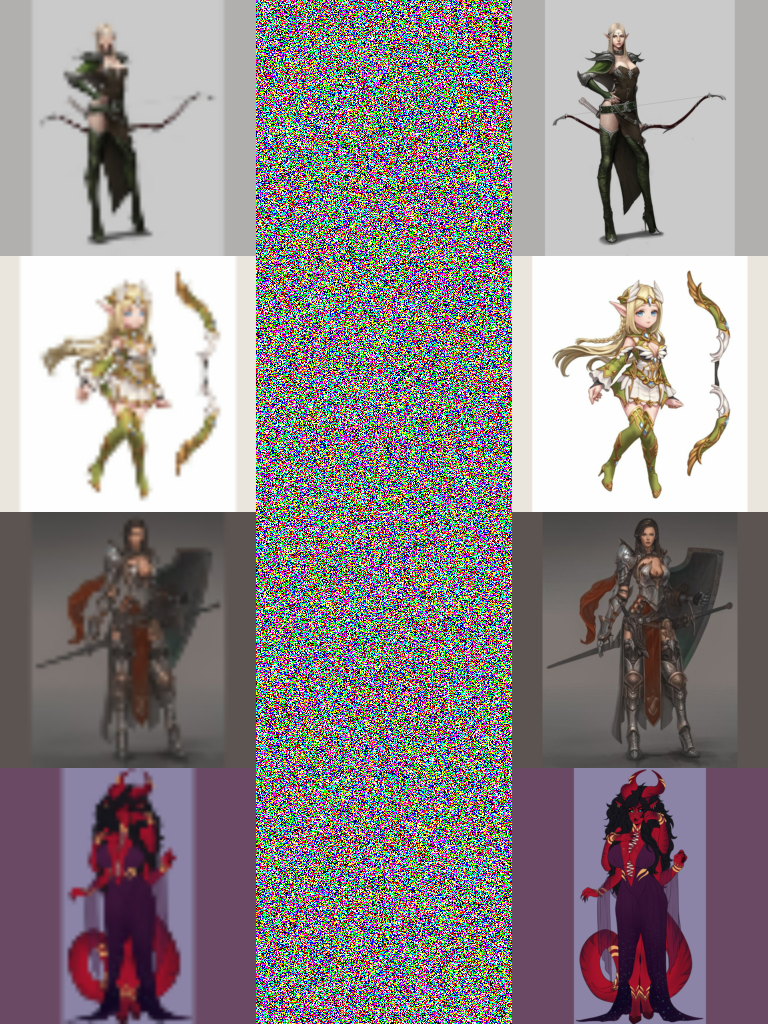

In [ ]:
compare_lr_sr_hr(lr_64.cpu(),sr_out.cpu(),hr_256.cpu())

In [ ]:
raise Exception("Everything below here is broken, from an earlier attempt")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- Sinusoidal embedding ---
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        """
        t: [B] or [B,1] tensor of timesteps in [0,1] or any positive scale
        returns: [B, dim] embedding
        """
        device = t.device
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb  # shape [B, dim]


In [ ]:
class SRUNet(nn.Module):
    def __init__(self, in_channels=6, out_channels=3, base_channels=64):
        super().__init__()
        # downsample
        self.enc1 = nn.Conv2d(in_channels, base_channels, 3, padding=1)
        self.enc2 = nn.Conv2d(base_channels, base_channels*2, 3, padding=1)
        self.enc3 = nn.Conv2d(base_channels*2, base_channels*4, 3, padding=1)
        # bottleneck
        self.mid = nn.Conv2d(base_channels*4, base_channels*4, 3, padding=1)
        # upsample (note channel reductions!)
        self.dec3 = nn.Conv2d(base_channels*4, base_channels*2, 3, padding=1)
        self.dec2 = nn.Conv2d(base_channels*2, base_channels, 3, padding=1)
        self.dec1 = nn.Conv2d(base_channels, out_channels, 3, padding=1)
        # timestep embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, base_channels*4),
            nn.ReLU(),
            nn.Linear(base_channels*4, base_channels*4),
        )
        self.base_channels = base_channels

    def forward(self, x, cond, t):
        # x: [B,3,H,W], cond: [B,3,H,W], t: [B]
        x = torch.cat([x, cond], dim=1) # -> [B,6,H,W]
        B = x.shape[0]
        t_emb = self.time_mlp(t[:,None]).view(B, self.base_channels*4, 1, 1)

        e1 = F.relu(self.enc1(x))                   # [B,base,H,W]
        e2 = F.relu(self.enc2(F.avg_pool2d(e1,2)))  # [B,2*base,H/2,W/2]
        e3 = F.relu(self.enc3(F.avg_pool2d(e2,2)))  # [B,4*base,H/4,W/4]

        mid = F.relu(self.mid(e3) + t_emb)          # [B,4*base,H/4,W/4]

        d3 = F.interpolate(mid, scale_factor=2, mode='nearest')  # [B,4*base,H/2,W/2]
        d3 = F.relu(self.dec3(d3)) + e2             # now [B,2*base,H/2,W/2]

        d2 = F.interpolate(d3, scale_factor=2, mode='nearest')   # [B,2*base,H,W]
        d2 = F.relu(self.dec2(d2)) + e1             # [B,base,H,W]

        out = self.dec1(d2)                         # [B,3,H,W]
        return out


In [ ]:
if sanity_test := True:
    noisy = torch.randn(2, 3, 128, 128)
    cond  = torch.randn(2, 3, 128, 128)
    t     = torch.rand(2)
    sr_model = SRUNet(in_channels=6, out_channels=3, base_channels=64)
    out = sr_model(noisy, cond, t)
    print(out.shape)  # ✅ [2, 3, 128, 128]


torch.Size([2, 3, 128, 128])


In [ ]:

train_dataset,paired_dataset = get_datasets(data_root)
train_loader = DataLoader(paired_dataset, batch_size=4, shuffle=True)

In [ ]:
import matplotlib.pyplot as plt

@torch.no_grad()
def sr_infer(sr_model, lr_imgs, device=device, sigma=0.1):
    """
    lr_imgs: [B,3,H_lr,W_lr] in [-1,1]
    Returns: [B,3,H_hr,W_hr] super-resolved images
    """
    sr_model.eval()
    
    # Upsample LR -> HR
    hr_size = 2 * lr_imgs.shape[-1]  # 64->128
    cond_lr_up = F.interpolate(lr_imgs, size=(hr_size, hr_size),
                               mode='bilinear', align_corners=False)
    
    # Add small noise for demo purposes
    noise = torch.randn_like(cond_lr_up) * sigma
    noisy_hr = cond_lr_up + noise
    
    # t placeholder (just scalar for demonstration)
    t = torch.zeros(lr_imgs.shape[0], device=device)
    
    # Concatenate noisy HR + conditioning
    input_tensor = torch.cat([noisy_hr, cond_lr_up], dim=1)  # [B,6,H_hr,W_hr]
    
    # Run SR model
    sr_imgs = sr_model(noisy_hr, cond_lr_up, t)
    
    # Clip / rescale back to [0,1] for visualization
    #sr_imgs = (sr_imgs.clamp(-1,1)+1)/2

    hr_pred = (cond_lr_up + sr_imgs).clamp(-1,1)

    return sr_imgs.cpu(), hr_pred.cpu()


def tensor_to_base64(img_tensor, auto_contrast = False):
    """
    Convert a [C,H,W] tensor (scaled [-1,1]) to a base64-encoded PNG for HTML.
    """
    #img_tensor = ((img_tensor.clamp(-1,1) + 1) * 0.5 * 255).byte()  # [0,255]
    img_tensor = (img_tensor.clamp(-1,1) + 1) * 0.5

    if auto_contrast:
        # Flatten spatial dims per channel, get min/max, then rescale
        C = img_tensor.shape[0]
        for c in range(C):
            channel = img_tensor[c]
            min_val = channel.min()
            max_val = channel.max()
            if max_val > min_val:
                img_tensor[c] = (channel - min_val) / (max_val - min_val)
            else:
                img_tensor[c] = c
    img_tensor = (img_tensor * 255).byte()
    img_np = img_tensor.permute(1,2,0).cpu().numpy()  # HWC
    img_pil = Image.fromarray(img_np)
    buffer = io.BytesIO()
    img_pil.save(buffer, format="PNG")
    b64_str = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return f"data:image/png;base64,{b64_str}"

def lr_sr_pairs_html(lr_imgs, sr_imgs, hd_pred, n=4, container_width=600):
    """
    Return HTML string with LR/SR image pairs in a flex container.
    
    lr_imgs, sr_imgs: tensors [B, C, H, W], values in [-1,1]
    n: number of pairs to show
    container_width: width of the container div in px
    """
    B = min(n, lr_imgs.shape[0])
    html_parts = [f'']
    
    for i in range(B):
        lr_b64 = tensor_to_base64(lr_imgs[i])
        sr_b64 = tensor_to_base64(sr_imgs[i])#, auto_contrast=True)
        hd_b64 = tensor_to_base64(hd_pred[i])
        html_parts.append(f"""
        <div style="display:flex; flex-wrap: wrap; margin:2px; width:100%">
            <div style="flex: 0 0 auto;"><img src="{lr_b64}" style="width:256px"/></div>
            <div style="flex: 0 0 auto;"><img src="{sr_b64}" style="width:256px"/></div>
            <div style="flex: 0 0 auto;"><img src="{hd_b64}" style="width:256px"/></div>
        </div>
        """)
    
    html_parts.append("")
    return "\n".join(html_parts)


def show_progress(sr_model,paired_dataset):
    with torch.inference_mode():
        # Grab one HR image from your dataset
        #train_dataset,paired_dataset = get_datasets(data_root)

        hr_img, _ = paired_dataset[0]  # shape: [3, 128,128] or [3,256,256] depending on your setup
        hr_img = hr_img.unsqueeze(0).to(device)  # add batch dim

        # Create LR version for conditioning
        lr_img = F.interpolate(hr_img, size=(64,64), mode='bilinear', align_corners=False)

        # Run super-resolution
        sr_img,hr_pred = sr_infer(sr_model, lr_img, device=device)

        # Visualize
        #show_lr_hr_pairs(lr_img.detach().cpu(), sr_img.detach().cpu(), n=1)
        h = lr_sr_pairs_html(lr_img.detach().cpu(), sr_img.detach().cpu(),hr_pred.detach().cpu())
        ipd.display(ipd.HTML(h))




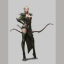
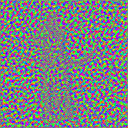
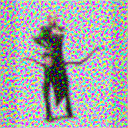

Epoch 1 Loss: 682.5712:  67%|██████▋   | 2153/3204 [00:39<00:19, 54.60it/s] 


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm

# --- Hyperparameters ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 1000
batch_size = 64         # small batch for memory efficiency
lr = 2e-4
HR_SIZE = 128
LR_SIZE = 64

### FIRST TRY
# --- Noise schedule & loss weight ---
# def linear_sigma_schedule(t, sigma_min=1e-4, sigma_max=1.0):
#     return sigma_min + t * (sigma_max - sigma_min)

# def sr_loss_weight(sigma):
#     # inverse weighting
#     return 1.0 / (sigma + 1e-8)

# Right now you’re probably sampling sigma uniformly or linearly. For SR, a log-linear or log-normal schedule works better:
# Why: Early in training, the model sees mostly “low-noise” images → easier to learn coarse structure.
#
# Later, higher sigma forces it to denoise harder, teaching fine details.
def sr_sigma_schedule(t, sigma_min=0.01, sigma_max=0.5):
    """
    t: tensor in [0,1]
    sigma_min: smallest noise level (easier examples)
    sigma_max: largest noise level (harder)
    Returns: sigma tensor
    """
    # log-space interpolation
    log_sigma_min = torch.log(torch.tensor(sigma_min))
    log_sigma_max = torch.log(torch.tensor(sigma_max))
    sigma = torch.exp(log_sigma_min + t * (log_sigma_max - log_sigma_min))
    return sigma

# Currently you may just use 1/sigma or uniform weights. Using EDM-style weighting stabilizes training:
# This automatically downweights very tiny noise (easy) and very large noise (hard) in a balanced way.
def sr_loss_weight(sigma, sigma_data=0.5):
    # EDM-style weighting
    return (sigma ** 2 + sigma_data ** 2) / (sigma * sigma_data) ** 2


# --- Prepare LR condition (upsample to HR size) ---
def prepare_lr_condition(hr_imgs):
    """
    hr_imgs: [B,3,HR,HR]
    Returns: [B,3,HR,HR] upsampled from LR
    """
    lr_down = F.interpolate(hr_imgs, size=(LR_SIZE, LR_SIZE), mode='bilinear', align_corners=False)
    cond_lr_up = F.interpolate(lr_down, size=(HR_SIZE, HR_SIZE), mode='bilinear', align_corners=False)
    return cond_lr_up

# --- Instantiate model ---
sr_model = SRUNet(in_channels=6, out_channels=3, base_channels=64).to(device)
optimizer = Adam(sr_model.parameters(), lr=lr)

ema_decay = 0.999
import copy
ema_model = copy.deepcopy(sr_model).eval()


t0 = time.time()
next_update = t0 + 5
# --- Training loop ---
for epoch in range(epochs):
    pbar = tqdm(train_loader)
    for hr_imgs, _ in pbar:
        hr_imgs = hr_imgs.to(device)                            # [B,3,HR,HR]
        cond_lr_up = prepare_lr_condition(hr_imgs)              # [B,3,HR,HR]

        B = hr_imgs.shape[0]
        t = torch.rand(B, device=device)                        # uniform [0,1]
        #sigma = linear_sigma_schedule(t)                        # [B]  # first try
        sigma = sr_sigma_schedule(t)
        # sample noise
        noise = torch.randn_like(hr_imgs)
        noisy_hr = hr_imgs + noise * sigma.view(B,1,1,1)

        # forward pass
        noise_pred = sr_model(noisy_hr, cond_lr_up, t)

        # compute weighted MSE
        w = sr_loss_weight(sigma).view(B,1,1,1)
        loss = (w * (noise_pred - noise)**2).mean()

        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            for p, ema_p in zip(sr_model.parameters(), ema_model.parameters()):
                ema_p.data.mul_(ema_decay).add_(p.data, alpha=(1 - ema_decay))

        if time.time() > next_update:
            ipd.clear_output(wait=True)
            show_progress(ema_model,paired_dataset)
            next_update = time.time() + 1
            pbar.set_description(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

print("Done training SR model.")


In [ ]:
train_dataset,paired_dataset = get_datasets(data_root)
paired_dataset[0][1].shape

torch.Size([3, 128, 128])

In [ ]:
# import torch
# import torch.nn.functional as F
# from torch.optim import Adam
# from tqdm import tqdm
# import copy

# # --- Hyperparameters ---
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# HR_SIZE = 256
# LR_SIZE = 64
# batch_size = 8
# epochs = 10
# lr = 2e-4
# ema_decay = 0.999

# # --- Noise schedule ---
# def linear_sigma_schedule(t, sigma_min=1e-4, sigma_max=1.0):
#     return sigma_min + t * (sigma_max - sigma_min)

# def sr_loss_weight(sigma):
#     return 1.0 / (sigma + 1e-8)

# # --- LR condition ---
# def prepare_lr_condition(hr_imgs):
#     lr_down = F.interpolate(hr_imgs, size=(LR_SIZE, LR_SIZE), mode='bilinear', align_corners=False)
#     cond_lr_up = F.interpolate(lr_down, size=(HR_SIZE, HR_SIZE), mode='bilinear', align_corners=False)
#     return cond_lr_up

# # --- Instantiate model ---
# sr_model = SRUNet(in_channels=3, base_ch=64, emb_dim=128, use_attention=True).to(device)
# ema_model = copy.deepcopy(sr_model).eval()
# optimizer = Adam(sr_model.parameters(), lr=lr)

# #train_loader = DataLoader(train_dataset, batch_size=batch_size//4, shuffle=True, num_workers=0)


# _,paired_dataset = get_datasets(data_root)
# batch_size = 4
# train_loader = DataLoader(paired_dataset, batch_size=batch_size, shuffle=True)

# t0 = time.time()
# # --- Training loop ---
# for epoch in range(epochs):
#     for lr_imgs, hr_imgs in tqdm(train_loader):
#         hr_imgs = hr_imgs.to(device)
#         lr_imgs = lr_imgs.to(device)
#         cond_lr_up = prepare_lr_condition(lr_imgs)

#         B = hr_imgs.shape[0]
#         t = torch.rand(B, device=device)  # uniform in [0,1]
#         sigma = linear_sigma_schedule(t)  # [B]

#         # Add noise to HR images
#         noise = torch.randn_like(hr_imgs)
#         noisy_hr = hr_imgs + noise * sigma.view(B,1,1,1)

#         # Forward pass
#         noise_pred = sr_model(noisy_hr, cond_lr_up, t)

#         # Weighted MSE loss
#         loss_map = (noise_pred - noise) ** 2
#         w = sr_loss_weight(sigma).view(B,1,1,1)
#         loss = (w * loss_map).mean()

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         print(loss)
#         # EMA update
#         with torch.no_grad():
#             for p, ema_p in zip(sr_model.parameters(), ema_model.parameters()):
#                 ema_p.data.mul_(ema_decay).add_(p.data, alpha=(1 - ema_decay))


  0%|          | 0/2572 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 5.78 GiB of which 814.19 MiB is free. Including non-PyTorch memory, this process has 4.60 GiB memory in use. Of the allocated memory 3.60 GiB is allocated by PyTorch, and 905.32 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import torch
import torch.nn.functional as F

@torch.no_grad()
def sr_sample(sr_model, lr_img, num_steps=18, sigma_min=0.002, sigma_max=0.5, device='cuda'):
    """
    Generate high-res image from low-res input using SRUNet.

    Args:
        sr_model: trained SRUNet
        lr_img: tensor [C,H,W] scaled to [-1,1]
        num_steps: number of diffusion steps
        sigma_min: min noise
        sigma_max: max noise
        device: 'cuda' or 'cpu'

    Returns:
        denoised HR image [1,C,HR_SIZE,HR_SIZE]
    """
    sr_model.eval()
    
    # Prepare LR conditioning: upsample to HR
    lr_img = lr_img.unsqueeze(0).to(device)  # [1,C,H,W]
    HR_SIZE = sr_model.inc.weight.shape[-1] * 4  # rough estimate from network
    cond_lr_up = F.interpolate(lr_img, size=(HR_SIZE, HR_SIZE), mode='bilinear', align_corners=False)
    
    # Initialize noisy HR image
    x_next = torch.randn_like(cond_lr_up) * sigma_max
    
    # Linear noise schedule
    t_steps = torch.linspace(1.0, 0.0, num_steps, device=device)
    sigmas = sigma_min + t_steps * (sigma_max - sigma_min)
    
    for i, sigma in enumerate(sigmas):
        sigma = sigma.view(1)
        
        # Preconditioning (simple EDM-style, can adjust)
        c_in = 1 / (sigma**2 + 0.5**2)**0.5
        c_out = sigma * 0.5 / (sigma**2 + 0.5**2)**0.5
        c_skip = 0.5**2 / (sigma**2 + 0.5**2)
        
        # Model prediction
        F_x = sr_model(c_in * x_next, cond_lr_up, sigma)
        denoised = c_skip * x_next + c_out * F_x
        
        # Euler update for next step
        if i < num_steps - 1:
            sigma_next = sigmas[i+1].view(1)
            c_in_next = 1 / (sigma_next**2 + 0.5**2)**0.5
            c_out_next = sigma_next * 0.5 / (sigma_next**2 + 0.5**2)**0.5
            c_skip_next = 0.5**2 / (sigma_next**2 + 0.5**2)
            
            F_x_next = sr_model(c_in_next * denoised, cond_lr_up, sigma_next)
            denoised_next = c_skip_next * denoised + c_out_next * F_x_next
            
            # Heun step
            d_cur = (x_next - denoised) / sigma
            d_prime = (denoised - denoised_next) / sigma_next
            x_next = x_next + (sigma_next - sigma) * (0.5*d_cur + 0.5*d_prime)
        else:
            x_next = denoised
    
    return x_next.clamp(-1,1)  # final HR image


In [ ]:
# lr_img: [3,64,64] tensor scaled [-1,1]
hr_gen = sr_sample(sr_model, lr_img, num_steps=18, device=device)

# Convert to [0,1] for visualization
img_vis = (hr_gen[0].cpu() + 1)/2.0

import matplotlib.pyplot as plt
plt.imshow(img_vis.permute(1,2,0).numpy())
plt.axis('off')
plt.show()


NameError: name 'lr_img' is not defined